In [200]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 5)

from align_yaxis import align_yaxis

Populating the interactive namespace from numpy and matplotlib


# Read data

,open,high,low,close,vwap,volume,count
time,,,,,,,
2018-12-13 16:54:00,0.9955,0.9955,0.9955,0.9955,0.0000,0.0000,0
2018-12-13 16:55:00,0.9956,0.9956,0.9955,0.9955,0.9955,6822.4607,5
2018-12-13 16:56:00,0.9955,0.9955,0.9955,0.9955,0.0000,0.0000,0
2018-12-13 16:57:00,0.9955,0.9955,0.9955,0.9955,0.0000,0.0000,0
2018-12-13 16:58:00,0.9955,0.9955,0.9955,0.9955,0.0000,0.0000,0


18140


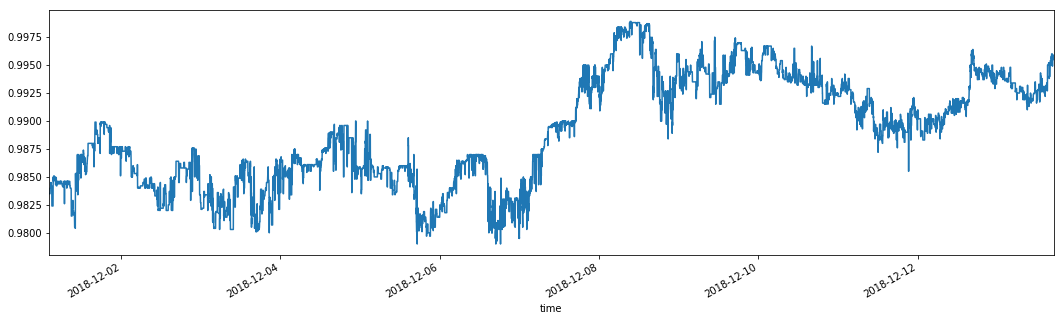

In [201]:
df = pd.read_csv('../data/USDTZUSD.csv')
s_to_ns = 1e9
df['time'] = (df['time']*s_to_ns).astype('datetime64[ns]')
df.set_index(['time'], inplace=True)
display(df.tail(5))
df['close'].plot()
print(len(df))

# Check if there is are lots of gaps

In [202]:
d = df.index.to_series().diff().iloc[1:]
holes = d[(d == pd.Timedelta(60000000000*2))]
display(holes)
display(df.loc[:holes.index[0]].tail(3))

time
2018-12-01 03:07:00   00:02:00
2018-12-01 03:12:00   00:02:00
2018-12-01 04:00:00   00:02:00
2018-12-13 15:04:00   00:02:00
2018-12-13 15:33:00   00:02:00
2018-12-13 16:28:00   00:02:00
2018-12-13 16:31:00   00:02:00
Name: time, dtype: timedelta64[ns]

,open,high,low,close,vwap,volume,count
time,,,,,,,
2018-12-01 03:04:00,0.9842,0.9842,0.9842,0.9842,0.0,0.0,0
2018-12-01 03:05:00,0.9842,0.9842,0.9842,0.9842,0.0,0.0,0
2018-12-01 03:07:00,0.9842,0.9842,0.9842,0.9842,0.0,0.0,0


# Get means and gradients

In [206]:


def calc_grads(df, fast_window_minutes, slow_window_minutes):
    fast_window, slow_window = str(fast_window_minutes) + 'Min', str(slow_window_minutes) + 'Min'
    fast_min_periods, slow_min_periods = int(fast_window_minutes * 0.8), int(slow_window_minutes * 0.8)
    p = df.loc[:, ['close']]
    p['mean-fast'] = p['close'].rolling(fast_window, fast_min_periods).mean()
    p['mean-slow'] = p['close'].rolling(slow_window, slow_min_periods).mean()
    means = p.loc[:, 'mean-fast':'mean-slow']
    index_diffs = means.index.to_series().diff().dt.total_seconds()
    p['grad-fast'] = p['mean-fast'].diff() / p.index.to_series().diff().dt.total_seconds()
    p['grad-slow'] = p['mean-slow'].diff() / p.index.to_series().diff().dt.total_seconds()
    p['grad-fast-mean'] = p['grad-fast'].rolling(grad_mean).mean()
    p['grad-slow-mean'] = p['grad-slow'].rolling(grad_mean).mean()
    p['mean-diff'] = p['mean-fast'] - p['mean-slow']
    return p

def plot_grads(g1, g2, ax):
    ax1 = g1.plot(color=ax.get_children()[1].get_color())
    plt.grid(True)
    ax2 = ax1.twinx()
    g2.plot(ax=ax2, color=ax.get_children()[2].get_color())
    align_yaxis(ax1, 0, ax2, 0)

    
# p_display = p.iloc[slice_display]
# ax = p_display.loc[:, ['close', 'mean-fast', 'mean-slow']].plot()
# plt.grid(True)

# plt.subplots(figsize=(18, 3))
# p_display['mean-diff'].plot()
# plt.grid(True)
# # plot_grads(p_display.loc[:, ['grad-fast']], p_display.loc[:, ['grad-slow']], ax)
# plot_grads(p_display.loc[:, ['grad-fast-mean']], p_display.loc[:, ['grad-slow-mean']], ax)

# Get signals

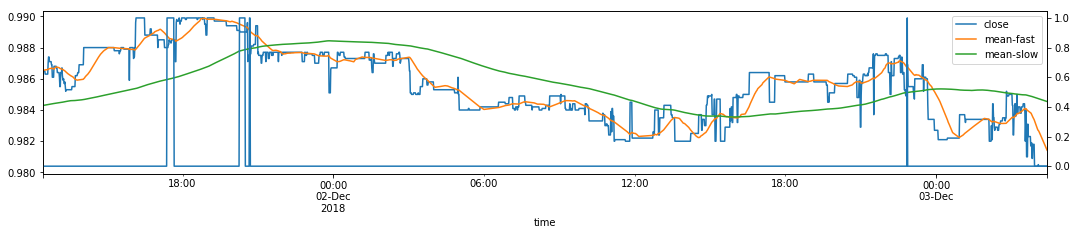

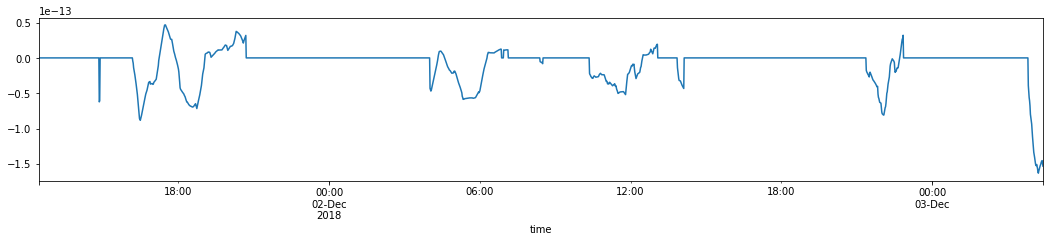

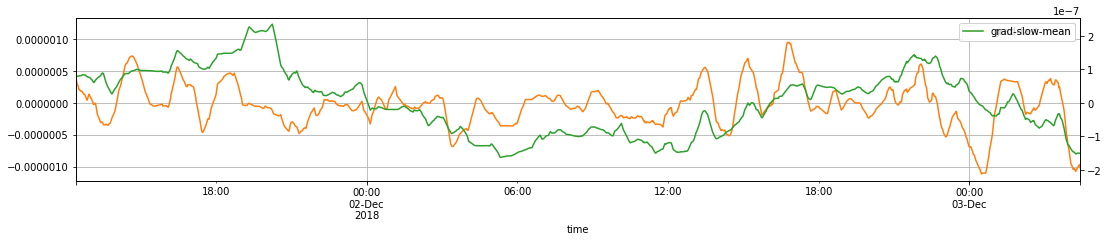

In [268]:
fast_window_minutes, slow_window_minutes = 60, 600
slice_display = slice(600, 3000)
grad_mean = 20
signal_threshold = 0.3e-13
slow_thresh = 1.0e-7

p = calc_grads(df, fast_window_minutes, slow_window_minutes)
p['signal'] = (p['grad-slow-mean'].abs() > slow_thresh) * -1 * p['grad-slow-mean'] * p['grad-fast-mean']
p['signal-bool'] = 0
p.loc[p['signal'] > signal_threshold, 'signal-bool'] = 1

p_display = p.iloc[slice_display]
ax1 = p_display.loc[:, ['close', 'mean-fast', 'mean-slow']].plot()
plt.subplots(figsize=(18, 3))
p_display['signal'].plot()
p_display['signal-bool'].plot(ax=ax1.twinx())
plot_grads(p_display.loc[:, ['grad-fast-mean']], p_display.loc[:, ['grad-slow-mean']], ax)

# Backtest

In [249]:
def calc_dd(prices, max_dd, take_profit, *, spread=0, print_progress=None):
    colname_dd_price = 'dd_price' # + '_' + str(max_dd)
    colname_dd_date = 'dd_date' # + '_' + str(max_dd)
    colname_dd_profit = 'dd_profit' # + '_' + str(max_dd)
    colname_dd_datediff = 'dd_datediff' # + '_' + str(max_dd)
    colname_dd_profit_speed = 'dd_profit_speed' # + '_' + str(max_dd)
    df = pd.DataFrame(index=prices.index)
    df.loc[:, colname_dd_price] = np.full_like(prices.values, None)
    df.loc[:, colname_dd_date] = np.full_like(df.index.values, None)
    for i, pos_open in enumerate(prices):
        if print_progress is not None and i > 0 and i % print_progress == 0:
            print('calc_dd, iteration #', i)
        max_price = pos_open * (1 - spread)
        for j, price in enumerate(prices.iloc[i:]):
            price = price * (1 - spread)
            max_price = max(max_price, price)
            profit = (price - pos_open) / pos_open
            drawdown = (max_price - price) / max_price
            if (drawdown > max_dd or profit > take_profit):
                df[colname_dd_price].values[i] = price
                df[colname_dd_date].values[i] = df.index[i+j]
                # print('break after', j)
                break

    df.loc[:, colname_dd_profit] = (df[colname_dd_price] - prices) / prices
    df.loc[:, colname_dd_datediff] = df[colname_dd_date] - df.index
    df.loc[:, colname_dd_profit_speed] = df[colname_dd_profit] / (df[colname_dd_datediff].dt.total_seconds() / 60 / 60 / 24 / 366)
    return df

In [267]:
max_dd = 0.0040
take_profit = 0.0060
dds = calc_dd(p['close'], max_dd, take_profit)
pdd = pd.concat([p, dds], axis=1)
print(len(p), len(dds), len(pdd))
# pdd.head()
signalled = pdd[(pdd['signal-bool'] > 0) & (pdd['grad-slow-mean'] > 0)]
signalled.loc[:, 'dd_profit':].describe()

18140 18140 18140


,dd_profit,dd_datediff,dd_profit_speed
count,161.000000,161,161.000000
mean,-0.001422,0 days 07:59:31.677018,-6.873902
std,0.003115,0 days 05:30:44.180325,17.051948
min,-0.004256,0 days 00:23:00,-88.366322
25%,-0.003419,0 days 03:04:00,-4.886208
50%,-0.002616,0 days 06:24:00,-2.465650
75%,-0.001006,0 days 14:57:00,-1.542496
max,0.006474,0 days 16:18:00,7.720130


# Grid search

In [270]:
param_grid = [
    {
        'fast_window_minutes': [1, 10, 100, 1000], 
        'slow_window_minutes': ['linear'],
        'grad_mean': [],
        'signal_threshold': [],
        'slow_thresh': [],
        'max_dd': [],
        'take_profit': [],
    },
 ]